## Numerical Optimization
### Assignement 3
### Leon Kalderon
#### case: Pagerank

sources: http://www.ams.org/publicoutreach/feature-column/fcarc-pagerank
<br> 
https://pdfs.semanticscholar.org/43b6/d922bcfcc8f8fcd3e7d22c8dc732653d9571.pdf
<br>
https://www.researchgate.net/publication/314235791_PageRank_Algorithm
<br>
https://web.stanford.edu/class/cme324/saad.pdf
<br>plus the pdf attached to the file that was my main source

### Dataset
The given dataset is a directed graph that represents the connectivity matrix
for the webpages of Stanford University.

First of all, we read the data and we create a sparce matrix that represents the graph of connections between different links. Every column of the matrix represents a node(link) and in the rows that have values we can find the other nodes that the node is connected with .
<br>
Because some nodes have only incoming links and not outgoing we have to create a vector $d$ that has values 0's and 1's(the ones will be in the indecies of the nodes that are dangling points and they have no outgoing links), this is the vector that is refered on the paper as $a$ but we prefer to assign it as $d$ so we do not confuse it with the scalar a.

In [23]:
#we read the data and we create a sparce matrix
fname = 'stanweb.txt'
#import all the libraries that we will need
import numpy as np
from  scipy import sparse
from scipy.sparse import identity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve_triangular

def dataset2csr():
    row = []
    col = []    
    val = []
    with open(fname,'r') as f:
        for line in f.readlines():
            #unpack the elements of each line
            origin, destiny, weight = (x for x in line.split()[0:3])
            #We shift the nodes by -1 so the matrix have indecies from 0-n
            row.append(int(destiny)-1)
            col.append(int(origin)-1)
            val.append(float(weight))
    
    NODES = max(np.max(row),np.max(col)) + 1  
    S = sparse.csr_matrix((val,(row,col)),shape=(NODES,NODES))
    
    #dangling nodes
    #We create the vector d that will have 1's as value on the dangling points indecies.
    ind = np.setdiff1d(row, col)
    d = np.zeros(NODES)
    d[ind] = 1
    return S, d, NODES

%time S,d, NODES = dataset2csr()

Wall time: 6.99 s


In [24]:
np.sum(d)

172.0

### Teleportation

Our matrix assumes that a surfer can move only from one page to another by clicking on one of
the hyperlinks of the web page he is currently visiting. This does not seem to be realistic: the surfer
can also go to a certain webpage by entering the address of that page in the address bar of the
browser. This is called teleportation.
<br>
We add teleportation to the model by supposing that a surfer moves to a page by clicking with
probability α (with 0 < α < 1) and by teleportation with probability 1 - α. In the case of
teleportation, the probability distribution for moving to a page is that of the general preference
vector $p$.

$\textbf{Dangling columns}$
We now replace the dangling columns containing only entries equal to zero, by the general
vector $p$(it is a n-dim vector with values $1/n$). In general the dangling columns can be replaced by $p$ by adding to $S$ a
matrix containing the desired dangling columns: $S + pd^T$ 
<br>
with $d(i) = 1$ if the i-th column of S is a dangling column and 0 otherwise.

Our model can now be described as a convex combination of the
original matrix $S$ + $p$$d^T$ and the teleportation matrix $p$$1^T$ , existing only of columns equal to $p$,
as follows:

$G = a(S + pd^T) + (1-a)p1^T$

### Power Method

The Power method produces a sequence of vectors that converge to the eigenvector corresponding
to the dominant eigenvalue, under the following assumptions:
-   The square matrix concerned has a dominant eigenvalue.
-   The initial vector has a non-zero component in the direction of the eigenvector correspond-
ing to the dominant eigenvalue.

The algorithmic proccess of power method is quitte simple.
-  We start with a random vector $π_0$
-  Multiply the $π_{k+1}$ = $Gπ_k$ where $π_k$ is normalized
-  We stop the proccess when $||π_k - π_{k+1}|| < e$ ($e$ is user defined)

Because matrix $G$ has not a single entry equal to zero, the given algorithm
will be very slow. Besides that, there is an important reason why the implementation of the
current algorithm is not desirable: storing matrix G requires a lot of memory space, because
$N^2$ elements has to be stored. A sparser matrix would require less memory space. So, we have
to avoid multiplications with matrix G and use a sparser matrix instead. To that end we take
a closer look to the multiplication $Gπ_k$:

$Gπ = aSπ + αpd^Τ + (1-a)p1^Tπ$

Matrix $S$ is very sparse. Therefore,
the matrix multiplication $Sπ$ can be done very fast by using the correct python library. The inner product $d^T$(to
prevent dangling pages) is a simple calculation. Furthermore, note that $1^T$ = 1, because $π$
sums up to one. Applying this yields
<br>
$Gπ = aSπ + (ad^Tπ + 1 - a)p$ (p.7 pdf)

In [19]:
def power_method(S, a=0.85, epsilon=10**-8, d = d, converge = False):
    
    #converge: When this parameter is True we use this function in order to see how the components converge to their limits
    #d: it is a vector that contains 1 if the node is a dangling node and 0 otherwise (we created this vector when we read the data)
    
    #dimensions of the matrix
    n,_ = S.shape
    #(1-a)/n vector
    b = np.repeat((1-a)/n,n)
    
    p = np.ones(n)/n
    #we store a*S in order to avoid this multiplication in each iteration
    Salpha = a*S
    
    if converge == True:
        conv = np.zeros(n)
        
    #Initialize a random vector as starting point
    ranks = np.random.rand(n)
    
    i = 0
    flag = True    
    while flag:        
        i +=1        
        #calculate the ranks of the current iteration from the formula described above
        new_ranks = Salpha.dot(ranks) + (np.dot(np.dot(d,ranks),p)) + b
        #normalize the vector with the ranks
        new_ranks /= np.linalg.norm(new_ranks, ord = 1)
        
        #We store into the array conv the number of iterations that each componenent did until convergence. 
        if converge == True:
            conv[(abs(np.subtract(new_ranks,ranks)) <= epsilon) & (conv==0)] = i
            
        if np.linalg.norm(new_ranks-ranks,ord=1)<=epsilon:
            flag = False        
        ranks = np.copy(new_ranks)
    if converge == False:
        return ranks, i 
    else:
        #We return an array with the number of iterations every NODE needed to reach its limits
        #The nodes are ordered from the most important to the least ones
        return conv[ranks.argsort()[:][::-1]]

### Linear System Approach
We obtain a linear system of our model as follows

$π_{k+1} = G π_k$ $(1)$
<br>
with $G = a(S + pd^Τ) + (1-a)p1^T$
<br>
Now, we can simplify $(1)$to:
<br>
$π_{k+1} = a(S+pd^T)π_k + (1-a)p$
<br>
because $1^Tπ=1$, we rewrite it as a linear system:
<br>
$(I-a(S+pd^T))π = (1-a)p$ $(2)$
<br>

For reasons of notation, we will write $(2)$ as
<br>
$Aπ = (1-α)p$ with $A = (I-aH)$ , $H = S + pd^T$ 

### Iterative method- Gauss Siedel
Iterative methods generate a sequence of
approximate solutions ${x_k}$ of a linear system $Ax = b$. The basic iterative methods are based
on a certain splitting of matrix A in a matrix M for which the system $My = c$ is 'easy' to solve
and the remaining matrix
<br>
<br>
$R = M-A$,
<br>
which changes the linear system into
<br>
$Mx = Rx + b$
<br>
<br>
The corresponding iteration is 
<br>
$Mx_{k+1}=Rx_k + b$ $(3)$

### Gauss Siedel Iteration
<br>
The Gauss-Seidel iteration is based on a splitting of A in a lower and upper triangular part:
<br>
$M_G = diag(A) + lower(A)$ and
<br>
$R_G = M_G - A = diag(A) + lower(A) - A = -upper(A)$

However, in order to use the efficient computational calculations of sparce matricies, we can separate dangling nodes and we can rewrite these matricies as:
<br>
$M_{G_M}$ = diag($\grave{A}$) + lower($\grave{A}$), where $\grave{A} = I - aS$ which we can simplify to $M_{G_M}$ = $I -$diag($aS$) $-$ lower($aS$) $(4)$

Consequently, the upper triangular part will be:
<br>
$R_{G_M} = M_{G_M} - A = I - diag(aS) - lower(aS) - I + aS + apd^T$
<br>
$= upper(aS) + apd^T$ $=$ $\grave{R_{G_M}}$$+ apd^T$ with $\grave{R_{G_M}}$ $= upper(aS)$ $(5)$

With the above transformations, we can rewrite $(3)$ as:
<br>
$π_{k+1} = M^{-1}_{G_M}$$(\grave{R_{G_M}}π_k + apd^Tπ_k + b)$ $(6)$ This is the final formula that we will use in our code to find the dominant eigenvector 

In [20]:
def gauss_siedel(S, a = 0.85, e = 10**-8, d=d, converge = False):
    n,_ = S.shape    
    #We create the matrix described in equation (4)
    M_Gm = identity(n) - sparse.tril(S, k = 0)
    #(5)
    Rt_Gm = sparse.triu(S, k = 1)
    
    alphaS = a*S
    p = np.ones(n)/n
    #This is the b of the equation (3), we can see in in equation (2) that b =(1-a)*p
    b = (1-a) * p 
    
    if converge == True:
        conv = np.zeros(n)
    
    #Initialize a random vector as starting point
    ranks = np.random.rand(n)
    i = 0
    flag = True
    while flag:
        i += 1
        
        #This is the formula of equation (6)
        #spsolve_triangular() this function solves efficiently linear systems of sparce triangular matricies
        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve_triangular.html        
        new_ranks = spsolve_triangular(M_Gm,(Rt_Gm.dot(ranks) + a*p*np.dot(d,ranks) + b))
        #Normalize the vector       
        new_ranks /= np.linalg.norm(new_ranks,ord=1)
        
        #We store into the array conv the number of iterations that each componenent did until convergence. 
        if converge == True:
            conv[(abs(np.subtract(new_ranks,ranks)) <= e) & (conv==0)] = i       

        if np.linalg.norm(ranks-new_ranks, ord=1) <= e:
            flag = False
        ranks = new_ranks
        
    if converge == False:
        return ranks, i 
    else:
        #We return an array with the number of iterations every NODE needed to reach its limits
        #The nodes are ordered from the most important to the least ones
        return conv[ranks.argsort()[:][::-1]]

### Power Method and Gauss Siedel for a = 0.85

In [21]:
#Power method
%time ranks85_pm, iters = power_method(S, a = 0.85, d = d)

print('Top seven links with Power method',ranks85_pm.argsort()[-7:][::-1] + 1)
print()
print('Number of iterations:', iters)

Wall time: 2.25 s
Top seven links with Power method [ 89073 226411 241454 262860 134832 234704 136821]

Number of iterations: 95


In [22]:
ranks85_pm

array([5.33556392e-07, 1.17168578e-04, 8.27374909e-07, ...,
       5.37213605e-07, 1.80892335e-06, 1.47952695e-06])

In [82]:
%time ranks85_gs, iters = gauss_siedel(S,a = 0.85, d = d)

print('Top seven links with Gauss Siedel',ranks85_gs.argsort()[-7:][::-1] + 1)
print()
print('Number of iterations:', iters)

Wall time: 1min 50s
Top seven links with Gauss Siedel [ 89073 226411 241454 262860 134832 234704 136821]

Number of iterations: 60


$\textbf{Results for a = 0.85}$

Power Method 
<br>
top ranks: [ 89073 226411 241454 262860 134832 234704 136821]
<br>
iterations: 95
<br>
Execution Time : ~2sec

Gauss Seidel
<br>
top ranks: [ 89073 226411 241454 262860 134832 234704 136821]
<br>
iterations: 60
<br>
Execution time: ~ 100 sec

Observations
<br>
We observe that the two methods gave us the same top rated links. 
<br>
The execution of Gauss-Seidel method takes much more time than the execution of the Power method, while it finished in less iterations.
<br>
However, this huge difference in execution times may occur due to unoptimizated code.


### Power Method and Gauss Siedel for a = 0.99

In [8]:
#~35 secs
%time ranks99_pm, iters = power_method(S,a = 0.99, d = d)

print('Top eight links',ranks99_pm.argsort()[-7:][::-1] + 1)
print()
print('Number of iterations:', iters)

Wall time: 32.7 s
Top eight links [ 89073 281772 174665 226411 179645 271409 262860]

Number of iterations: 1451


In [6]:
# ~20 mins to execute (can be skipped)
# %time ranks99_gs, iters = gauss_siedel(S,a = 0.99, d = d)

# print('Top seven links with Gauss Siedel',ranks99_gs.argsort()[-7:][::-1] + 1)
# print()
# print('Number of iterations:', iters)

Wall time: 20min 29s
Top seven links with Gauss Siedel [281772  89073 174665 226411 179645 271409 262860]

Number of iterations: 608


$\textbf{Results for a = 0.99}$

Power Method 
<br>
top ranks: [ 89073 281772 174665 226411 179645 271409 262860]
<br>
iterations: 1451
<br>
Execution Time : ~35sec

Gauss Seidel
<br>
top ranks: [ 89073 281772 174665 226411 179645 271409 262860]
<br>
iterations: 608
<br>
Execution time: ~ 20 minutes

Observations
<br>
We observed that the top ranking links have changed. However, 89073 is still first.

### First 50 nodes for alpha 0.85-0.99

In [9]:
pm85 = ranks85_pm.argsort()[-51:][::-1]
pm99 =  ranks99_pm.argsort()[-51:][::-1]

np.sum(np.isin(pm85, pm99))

26

$\textbf{Results}$

We observe that only 26 of the 50 nodes are the same for a 0.99 and 0.85.
<br>
However, the most of these 26 nodes are not in the same ranking place.

### Convergence

In order to see how the NODES converge to their limit, we store in a vector the number of iterations that each component needs to reach its limits.
<br>
As  limit we consider that $|π_i^k - π_i^{k+1}| <= 10^{-8}$

$\textbf{Power Method Converge}$

In [68]:
#The number of iterations every node needs until it converges to its limits 
#The array conv its ordered from the most important nodes to the least important 
conv_pm = power_method(S, converge = True)

Because we have too many nodes we splitted them to chunks of equal size and then we found the mean of each chunk

In [69]:
#Split into chunks
chunks_pm = np.array_split(conv_pm,100)

In [70]:
#Calculate the mean of each chunk
mean_iter_per_chunk_pm = []
for i in range(0,100):
    mean_iter_per_chunk_pm.append(np.mean(chunks_pm[i]))

In [60]:
mean_iter_per_chunk_pm

[26.9790780141844,
 21.442553191489363,
 19.626595744680852,
 18.451933309684286,
 19.404043987229514,
 18.25008868393047,
 16.842497339482087,
 16.574671869457255,
 16.505498403689252,
 18.67009577864491,
 18.39091876551969,
 20.38701667257893,
 21.807023767293366,
 22.853494146860587,
 22.555516140475344,
 25.44519333096843,
 23.337353671514723,
 24.736076622915927,
 16.46009223128769,
 13.469670095778644,
 11.870521461511174,
 10.86200780418588,
 10.876551968783257,
 11.821213196168854,
 12.728981908478184,
 14.137282724370344,
 12.628591699184108,
 10.891450869102519,
 13.290528556225611,
 13.269953884356156,
 15.808797445902803,
 14.9418233416105,
 14.025540971975879,
 13.490244767648102,
 10.578573962398014,
 10.101809152181625,
 9.72685349414686,
 8.27172756296559,
 8.909542390918766,
 8.117062788222775,
 8.792479602695991,
 8.840368925150763,
 8.57396239801348,
 8.472507981553742,
 8.53600567577155,
 8.515076268180206,
 8.367506207875133,
 8.15431003902093,
 7.958495920539198,


<function matplotlib.pyplot.show(*args, **kw)>

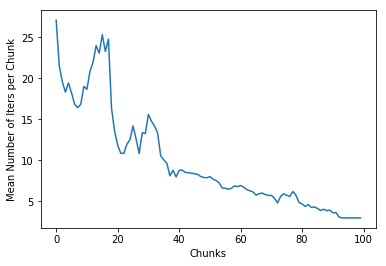

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_iter_per_chunk_pm)
plt.ylabel('Mean Number of Iters per Chunk')
plt.xlabel('Chunks')
plt.show

Results:
<br>
Generally, we observe that for the Power Method the most important nodes need more iterations until they reach their limits.

$\textbf{Gauss Siedel Converge}$

We work the same way for the Gauss Siedel method
<br>
~2min execution time

In [52]:
conv_gs = gauss_siedel(S, converge = True)
chunks_gs = np.array_split(conv_gs,100)
#Calculate the mean of each chunk
mean_iter_per_chunk_gs = []
for i in range(0,100):
    mean_iter_per_chunk_gs.append(np.mean(chunks_gs[i]))
    

<function matplotlib.pyplot.show(*args, **kw)>

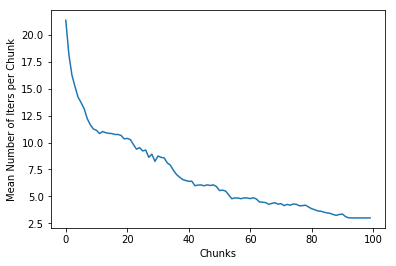

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_iter_per_chunk_gs)
plt.ylabel('Mean Number of Iters per Chunk')
plt.xlabel('Chunks')
plt.show

Results:
<br>
Same as the Power Method, with the Gauss Siedel Method the most important nodes need more iterations until they reach their limits. 

### Theoretical excercises

$\textbf{Genereal}:$

main sources: https://web.stanford.edu/class/cs224w/slides/handout-page_rank.pdf
<br>
http://snap.stanford.edu/class/cs246-2014/slides/09-pagerank.pdf

Let $r_i$ be the PageRank of node $i$, and $d_i$ be its outdegree. Then we can define the PageRank
of node $j$ to be:

 $r_i^{k+1} = \sum_{i->j}\frac{r_j^{k}}{d_j}$ where $r_j$ is the rank of page j and $d_j$ the outlinks.
 
 That is, each of the neighbors that point to node j contribute to j’s PageRank, and the
contribution is based on how authoritative the neighbor is (i.e. the neighbor’s own PageRank)
and how many nodes the neighbor endorses.

From this formulation, we can understand that every node's rank is dependent on its incoming links. More specifically, it is dependent from the importance of the nodes that link to the node $j$.
<br>
Also, every node, equally tranfers its importance to its outgoings links.


$\textbf{Teleportation}$

One of the problems with the way we formulated PageRank is that some nodes might not
have any out-links. In this case, the random web surfer gets stuck at a “dead end” and can’t
visit any more pages, ruining our plans. Similarly, the web surfer may get stuck in a “spider
trap” of pages where all the links only point to pages inside the spider trap. In that case, the
pages in the spider trap eventually absorb all the PageRank, leaving none of the PageRank
for other pages.
In order to deal with the spider trap problem, we add an escape route. We say that with
probability α (which is usually about 0.8 or 0.9), the web surfer follows an out-link at random,
but with probability 1 − α, he jumps to some random webpage. In the case of a dead end,
the web surfer jumps to a random webpage 100% of the time.
With this modification, the new PageRank equation becomes:

$r_i^{k+1} = \sum_{i->j}α*\frac{r_j^{k}}{d_j} + (1-α)\frac{1}{n}$

$\textbf{Question A}$

Let's assume that we add a new Node $X$ in our graph without any outgoing or ingoing links.
<br>
The first part of the formula it is not going to change because $X$ has not any connection with other nodes.
<br>
The second part of the equation ($(1-α)\frac{1}{n}$) will slightly change to $(1-α)\frac{1}{n+1}$ but because $n$ is a very large number we can say that this difference is insignificant, thus $(1-α)\frac{1}{n} \cong (1-α)\frac{1}{n+1}$.

All in all, when we add a node that is disconnected from the graph the rankinks do not change.

$\textbf{Question B}$

Let's assume that we add a new node $Y$ in our graph that has only one outgoing link to the node $X$ of the previous question.

The ranking of page $X$ will slightly increace by the ranking of page $Y$.
<br>
$r'_x = r_x + \frac{r_y}{1}$ ($\frac{r_y}{1}$ because $r_y$ has only one outgoing link)
<br>
However, the only ranking that these two pages have derives from the teleportation part of the equation so:
<br>
$r'_x = 2*(1-α)\frac{1}{n+2}$

Also, we can say that the rest PageRanks remain unchange because $n$ is very big thus $(1-α)\frac{1}{n} \cong (1-α)\frac{1}{n+2}$

$\textbf{Question C}$

Now, we assume that we add one more new node $Z$.
<br>
In order to maximize $X$ we have to add new connections from $X$ to the other two nodes ($Y,Z$) in order to increace the importance of these two nodes. Following the same logic, we connect $Y$ with $X, Z$ and $Z$ with $X, Y$. That way, we maximize the importance of all nodes, thus the importance that $X$ derives from the other two nodes. 

$\textbf{Question D}$

Adding new connections to older important pages will not improve the rank of $X$. The rank of $X$ is dependent on its incoming nodes; None of the old pages is linking to $X$. The same holds for $Y$ and $Z$. Even if these pages(Y,Z) link to $X$ and by increasing their ranks we increase the rank of $X$, this method will not increase the ranks of $Y$, $Z$ so neither of $X$


$\textbf{Question E}$

Thinking the same way as question C. When we have $m$ nodes and we want to maximize the rank of $X$ we have to connect them all to each other (including $X$) so recursively we maximize the rank of these nodes thus the ranking that $X$ derives from these $m$ nodes.


